In [1]:
from helper import *
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import duckdb
from collections import Counter
from IPython.display import display as dp
import re
import warnings


# Filter out FutureWarnings
warnings.simplefilter(action="ignore", category=FutureWarning)

pd.options.display.max_columns = None

sns.set_style("darkgrid")

#### Data Loading and Cleaning

In [2]:
# # only run these once
duckdb.sql("INSTALL sqlite")
duckdb.sql("LOAD sqlite")
duckdb.sql("ATTACH './data/database.sqlite' (TYPE sqlite);")

In [3]:
bprint("All tables in the database: ")
qry("SHOW ALL TABLES")


All tables in the database: 


,database,schema,name,column_names,column_types,temporary
0,database,main,Country,"[id, name]","[BIGINT, VARCHAR]",False
1,database,main,League,"[id, country_id, name]","[BIGINT, BIGINT, VARCHAR]",False
2,database,main,Match,"[id, country_id, league_id, season, stage, dat...","[BIGINT, BIGINT, BIGINT, VARCHAR, BIGINT, VARC...",False
3,database,main,Player,"[id, player_api_id, player_name, player_fifa_a...","[BIGINT, BIGINT, VARCHAR, BIGINT, VARCHAR, BIG...",False
4,database,main,Player_Attributes,"[id, player_fifa_api_id, player_api_id, date, ...","[BIGINT, BIGINT, BIGINT, VARCHAR, BIGINT, BIGI...",False
5,database,main,Team,"[id, team_api_id, team_fifa_api_id, team_long_...","[BIGINT, BIGINT, BIGINT, VARCHAR, VARCHAR]",False
6,database,main,Team_Attributes,"[id, team_fifa_api_id, team_api_id, date, buil...","[BIGINT, BIGINT, BIGINT, VARCHAR, BIGINT, VARC...",False
7,database,main,sqlite_sequence,"[name, seq]","[BLOB, BLOB]",False


In [4]:
country = qry("SELECT * FROM database.Country")
league = qry("SELECT * FROM database.League")
game = qry("SELECT * FROM database.Match")  # rename it to game
player_attributes = qry("SELECT * FROM database.Player_Attributes")
team = qry("SELECT * FROM database.Team")
team_attributes = qry("SELECT * FROM database.Team_Attributes")
sqlite_sequence = qry("SELECT * FROM database.sqlite_sequence")
# player has one mismatched dtype, cast all dtypes to be varchar
duckdb.sql("SET GLOBAL sqlite_all_varchar = true")
player = qry("SELECT * FROM database.Player")

📊 Country

In [5]:
basic_df_info(country, head=False)


null count:
0

duplication count:
0

data shape:
(11, 2)

df:


,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


📊 League

In [6]:
basic_df_info(league, head=False)


null count:
0

duplication count:
0

data shape:
(11, 3)

df:


,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [7]:
# combine league and country tables to league table
league["country"] = country.name
league = drop_cols(league, ["id"])
league.rename(columns={"country_id": "league_id"}, inplace=True)
bprint("Combined league table")
league.head(3)


Combined league table


,league_id,name,country
0,1,Belgium Jupiler League,Belgium
1,1729,England Premier League,England
2,4769,France Ligue 1,France


📝 There are 11 countries and 11 leagues. \
Each country has 1 league, and country_id is the same as league_id \
so we combine these two tables together.

📊 Game

In [8]:
basic_df_info(game)
print(list(game.columns))

game = game.rename(
    columns={
        "id": "game_id",
        "home_team_api_id": "home_team_id",
        "away_team_api_id": "away_team_id",
    }
)

# drop columns
game = game.drop(
    columns=[
        "country_id",
        "stage",
        "match_api_id",
        "shoton",
        "shotoff",
        "foulcommit",
        "card",
        "cross",
        "corner",
        "possession",
        "goal",
    ]
)

# cast date column
game["date"] = pd.to_datetime(game.date)


null count:
407395

duplication count:
0

data shape:
(25979, 115)

df:


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.4,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.8,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.2,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.9,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.3,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.5,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.5,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75


['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_player_2', 'home_player_

📊 Null handling: \
There are many nulls, let's take a closer look


column null proportion


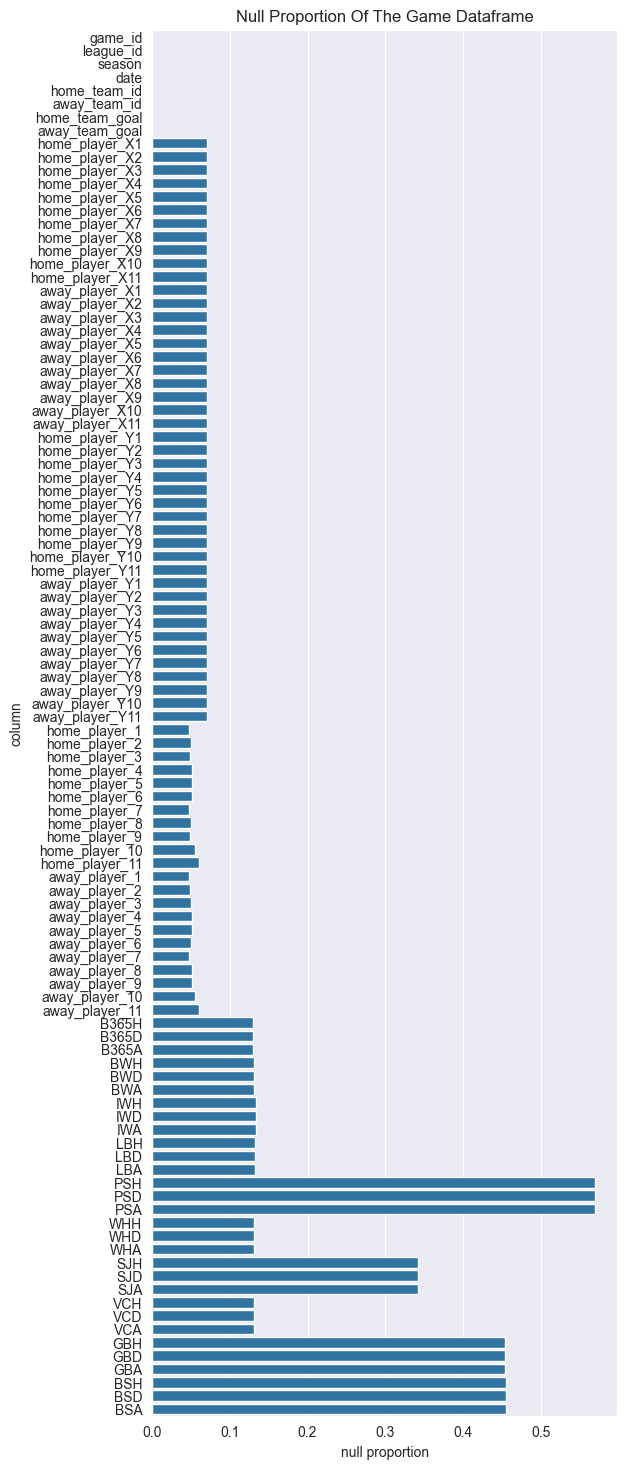


data loss if all null values dropped:
90.0%


In [9]:
bprint("column null proportion")
game_null = game.isnull().mean()
fs(6, 18)
sns.barplot(y=game_null.index, x=game_null.values)
plt.xlabel("null proportion")
plt.ylabel("column")
plt.title("Null Proportion of the game dataframe".title())
s()
gc_na_loss = round(game.dropna().shape[0] / game.shape[0], 2)
bprint("data loss if all null values dropped:")
print(f"{round((1 - gc_na_loss), 2)*100}%")

📝 Game

There are 115 columns in game df. \
We can roughly classify them into 5 feature groups:
1. basic game info
2. home and away players formation (coordinates)
3. home and away players id
4. game outcome 
5. bookie odds

As the main target of this project is to predict game result, we would first \
drop some features we won't be looking into.

Here we drop: \
`country_id, stage, match_api_id, shoton,shotoff,` \
` foulcommit, card, cross, goal, corner, possession` columns.

▵ duplication: \
There is no duplication in game df.

▵ null: \
Apart from the basic game info columns, every column has certain proportion of \
null values. We can see that, columns that are related have similar \
proportion of nulls. eg: all player position related columns

If we drop all the null values altogether, we would lose 90% of the data. \
This means that high percentage of nulls in different columns are not \
overlapping in the same row.

> So we won't drop all the nulls in game df.

> Going forward, we would split some related features into separate dateframes, \
> and use them for analysis separately or join when needed. 


📊 Player

In [10]:
# player
player = drop_cols(player, ["id", "player_fifa_api_id"])
player = player.rename(columns={"player_api_id": "player_id"})
# cast date column
player["birthday"] = pd.to_datetime(player.birthday)

basic_df_info(player)


null count:
0

duplication count:
0

data shape:
(11060, 5)

df:


,player_id,player_name,birthday,height,weight
0,505942,Aaron Appindangoye,1992-02-29,182.88,187
1,155782,Aaron Cresswell,1989-12-15,170.18,146
2,162549,Aaron Doran,1991-05-13,170.18,163


📊 Player Attributes

- there are many features in player attributes, but for modeling, we would only \
take overall rating into consideration as it sums up all the player features.

In [11]:
# rename & drop some columns
player_attributes = player_attributes.rename(
    columns={"player_api_id": "player_id"})
player_attributes = drop_cols(
    player_attributes, ["id", "player_fifa_api_id", "potential"]
)
basic_df_info(player_attributes)
# cast date column
player_attributes["date"] = pd.to_datetime(player_attributes.date)

# drop na for overall_rating subset.
player_attributes = player_attributes.dropna(subset=["overall_rating"])[
    ["player_id", "date", "overall_rating"]
]

bprint("selected player_attributes: ")
player_attributes.head(3)


null count:
46465

duplication count:
1

data shape:
(183978, 39)

df:


,player_id,date,overall_rating,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,2016-02-18 00:00:00,67.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,2015-11-19 00:00:00,67.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,505942,2015-09-21 00:00:00,62.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0



selected player_attributes: 


,player_id,date,overall_rating
0,505942,2016-02-18,67.0
1,505942,2015-11-19,67.0
2,505942,2015-09-21,62.0


📝 
- `Player:` \
There's no null and duplication in player table. 

- `Player attributes:` \
Would only use overall_rating for further analysis and \
modeling, as it sums up the player characteristic well.


📊 Team

In [12]:
team = drop_cols(team, ["id", "team_fifa_api_id"])
team = team.rename(columns={"team_api_id": "team_id"})
basic_df_info(team)


null count:
0

duplication count:
0

data shape:
(299, 3)

df:


,team_id,team_long_name,team_short_name
0,9987,KRC Genk,GEN
1,9993,Beerschot AC,BAC
2,10000,SV Zulte-Waregem,ZUL


📊 Team Attributes
- team attributes are always in pair with the class of the attribute here, \
we would only use the class attribute and remove the numeric attributes.

In [13]:
team_attributes = drop_cols(team_attributes, ["team_fifa_api_id", "id"])
team_attributes = team_attributes.rename(columns={"team_api_id": "team_id"})
basic_df_info(team_attributes)
team_attributes.isnull().sum()

cols_to_drop = find_list_pattern(
    r".*(Speed|Dribbling|Passing|Crossing|Shooting|Pressure|Aggression|Width)$",
    team_attributes.columns,
)  # drop because it has many null vals
team_attributes = drop_cols(team_attributes, cols_to_drop)
class_cols = find_list_pattern(r".*Class$", team_attributes.columns)

# convert col names to slug case
ta_names = team_attributes.columns
ta_names_new = [camel_to_slug(i) for i in ta_names]
ta_dict = {ta_names[i]: ta_names_new[i] for i in range(len(ta_names))}
team_attributes = team_attributes.rename(columns=ta_dict)
team_attributes.date = pd.to_datetime(team_attributes.date)
bprint("selected team_attributes")
team_attributes.head(3)


null count:
969

duplication count:
1

data shape:
(1458, 23)

df:


,team_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,65,Normal,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover



selected team_attributes


,team_id,date,build_up_play_speed_class,build_up_play_dribbling_class,build_up_play_passing_class,build_up_play_positioning_class,chance_creation_passing_class,chance_creation_crossing_class,chance_creation_shooting_class,chance_creation_positioning_class,defence_pressure_class,defence_aggression_class,defence_team_width_class,defence_defender_line_class
0,9930,2010-02-22,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
1,9930,2014-09-19,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
2,9930,2015-09-10,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover


Now, let's encode the attribute classes to numeric values, the encode order \
here is based on soccer knowledge I found online. \
There are always 3 classes, we set the `best to be 1, worst to be -1`

In [14]:
class_cols = find_list_pattern(r".*class$", team_attributes.columns)

class_encode_map = {
    "build_up_play_speed_class": {"Balanced": 0, "Fast": 1, "Slow": -1},
    "build_up_play_dribbling_class": {"Little": -1, "Normal": 0, "Lots": 1},
    "build_up_play_passing_class": {"Mixed": 0, "Short": -1, "Long": 1},
    "build_up_play_positioning_class": {"Organised": 1, "Free Form": -1},
    "chance_creation_passing_class": {"Normal": 0, "Risky": -1, "Safe": 1},
    "chance_creation_crossing_class": {"Normal": 0, "Lots": 1, "Little": -1},
    "chance_creation_shooting_class": {"Normal": 0, "Lots": 1, "Little": -1},
    "chance_creation_positioning_class": {"Organised": 1, "Free Form": -1},
    "defence_pressure_class": {"Medium": 0, "Deep": -1, "High": 1},
    "defence_aggression_class": {"Press": 1, "Double": 0, "Contain": -1},
    "defence_team_width_class": {"Normal": 0, "Wide": 1, "Narrow": -1},
    "defence_defender_line_class": {"Cover": 1, "Offside Trap": -1},
}
for i in class_cols:
    team_attributes[i] = team_attributes[i].apply(
        lambda j: class_encode_map[i][j])

bprint("class encoded attributes: ")
team_attributes.head(3)


class encoded attributes: 


,team_id,date,build_up_play_speed_class,build_up_play_dribbling_class,build_up_play_passing_class,build_up_play_positioning_class,chance_creation_passing_class,chance_creation_crossing_class,chance_creation_shooting_class,chance_creation_positioning_class,defence_pressure_class,defence_aggression_class,defence_team_width_class,defence_defender_line_class
0,9930,2010-02-22,0,-1,0,1,0,0,0,1,0,1,0,1
1,9930,2014-09-19,0,0,0,1,0,0,0,1,0,1,0,1
2,9930,2015-09-10,0,0,0,1,0,0,0,1,0,1,0,1


---

### Feature Extraction

Going forward, game table would be used as the main table to hold features for \
modeling. Thus we would comb through the columns to extract useful information. \
And also combine features from other tables:

Here are some objectives: 

>1. Extract the bookie related columns to a different table.
>2. Combine player_coordinates columns (home/away_player_X/Y) \
columns into formation column.
>3. Merge features from player_attributes table to game table.
>4. Convert home and away data in game into long form
>5. Extract features from team_attributes table and combine with game_result. 


📊 1. Bookie
- BWH, BWD, BWA, ...

Game odds is given by different bookies in game table. \
Here we won't look at individual bookie, but at the mean of all bookies. \
Also, we would convert bookie odds into win probability for easier understanding. 

The odds here is calculated as follows:
> bookie_odds = 1/probability 

For example, in order to get the probability of home_wins, we have to calculate:
> home_wins_probability = 1/home_odds / (1/home_odds + 1/draw_odds + 1/away_odds)

In [15]:
bookie_cols = find_list_pattern(r"^[A-Z]", game.columns)
# get bookies mean of each game
home_wins_cols = find_list_pattern(r".*H$", game.columns)
draw_cols = find_list_pattern(r".*D$", game.columns)
away_wins_cols = find_list_pattern(r".*A$", game.columns)

bookie = game[bookie_cols].astype("float").copy()
bookie["game_id"] = game.game_id
# drop all bookie columns
game = drop_cols(game, bookie_cols)

# calculate bookie odd mean for each game
bookie["bookie_home_wins_mean"] = bookie[home_wins_cols].mean(axis=1)
bookie["bookie_draw_mean"] = bookie[draw_cols].mean(axis=1)
bookie["bookie_away_wins_mean"] = bookie[away_wins_cols].mean(axis=1)
bookie_mean_cols = find_list_pattern(r".*_mean", bookie.columns)


# distribution of bookie odd means
bookie_probability = qry(
    """
SELECT
  game_id,
  1/bookie_home_wins_mean/ (1/bookie_home_wins_mean + 1/bookie_draw_mean + 1/bookie_away_wins_mean) 
  AS bookie_home_wins_probability_mean,
  1/bookie_away_wins_mean/ (1/bookie_home_wins_mean + 1/bookie_draw_mean + 1/bookie_away_wins_mean)
  AS bookie_away_wins_probability_mean,
  1/bookie_draw_mean/ (1/bookie_home_wins_mean + 1/bookie_draw_mean + 1/bookie_away_wins_mean) 
  AS bookie_draw_probability_mean
FROM   
  bookie
"""
)

assert (
    game.shape[0] == bookie_probability.shape[0] == bookie.shape[0]
), "game and bookie_probability shape mismatch"

# merge & clean up
bookie = merge_df(bookie, bookie_probability, on="game_id", how="left")
bookie = drop_cols(bookie, bookie_mean_cols)

bprint("bookie table:")
bookie.head(3)


bookie table:


,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,game_id,bookie_home_wins_probability_mean,bookie_away_wins_probability_mean,bookie_draw_probability_mean
0,1.73,3.4,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.8,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,1,0.511405,0.216815,0.271780
1,1.95,3.2,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.9,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,2,0.474088,0.248915,0.276997
2,2.38,3.3,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.5,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.5,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75,3,0.366408,0.354568,0.279024


📊 2. Team formation
- home_player_X1, home_player_X2, ...

Formation is the number of players in X Y coordinates on the field \
This information can represent the strategy of the team. 
> In this analysis, we only consider the Y coordinates.

The first position is always the goal keeper, followed by defender, midfilder, \
and forward. \
For example, common soccer formation: 1433


In [16]:
# find formation related columns
home_form_cols = find_list_pattern(r"home_player_Y", game.columns)
away_form_cols = find_list_pattern(r"away_player_Y", game.columns)
x_coord_cols = find_list_pattern(r"(home|away)_player_X", game.columns)

# convert player Y coordinates to formations
home_form = game[home_form_cols]
home_form = [list(Counter(i).values()) for i in np.array(home_form)]
home_form = ["".join(map(str, i)) for i in home_form]
home_form = list(
    map(lambda i: None if i in ["11111111111", "2111111111"] else i, home_form)
)
away_form = game[away_form_cols]
away_form = [list(Counter(i).values()) for i in np.array(away_form)]
away_form = ["".join(map(str, i)) for i in away_form]
away_form = list(
    map(lambda i: None if i in ["11111111111", "2111111111"] else i, away_form)
)

# add home and away team formations
game["home_formation"] = home_form
game["away_formation"] = away_form

# drop player x,y coord columns
game = drop_cols(game, home_form_cols + away_form_cols + x_coord_cols)

bprint("home and away formation columns: ")
game[["home_formation", "away_formation"]].tail(3)


home and away formation columns: 


,home_formation,away_formation
25976,14231,14231
25977,1433,14231
25978,1442,14231


📊 3. Add the most relevant player score to each games on player_ids
- home_player_1, home_player_2, ...

We'd like to replace the player_id with the player over_all score in game table, \
to use it as a potential feature for modeling.

There are multiple overall score for the same player logged in at different \
date. 

>We need to get the player overall score that is logged `before the game` <br>
>to avoid data leak. And to be as relevant as possible, we need to select the \
>logged score with date as close to the game date as possible.


- map the most relevant player_score to players in games

In [17]:
game_player_cols = find_list_pattern(r"(home|away)_player_\d+", game.columns)

game_player_score_map = pd.DataFrame(
    {"game_id_player_id": [], "game_date": [], "overall_rating": []}
)

# select the player score that is logged closest to the time of the game, and
for i in game_player_cols:
    latest_score = qry(
        f"""
    WITH player_game_score AS (
      SELECT
        game.game_id,
        game.game_id || '-' || CAST(player_attributes.player_id AS FLOAT) AS game_id_player_id,
        player_attributes.player_id, 
        player_attributes.date AS log_date,
        game.date AS game_date,
        EPOCH(game.date) - EPOCH(player_attributes.date) 
        AS game_log_epoch_diff,
        
        RANK() OVER (
          PARTITION BY 
            game_date, player_id
          ORDER BY 
            EPOCH(game.date) - EPOCH(player_attributes.date)
        ) AS log_date_rank,
        player_attributes.overall_rating
      
        FROM
          player_attributes
        LEFT JOIN 
          game
        ON
          game.{i} = player_attributes.player_id 
        WHERE
          (EPOCH(game.date) - EPOCH(player_attributes.date)) > 0 
        ORDER BY
          player_attributes.player_id )
          
      SELECT 
        game_id, 
        game_id_player_id, 
        game_date, 
        log_date, 
        overall_rating
      FROM player_game_score
      WHERE log_date_rank = 1
           
  """
    )
    game_player_score_map = pd.concat([game_player_score_map, latest_score])

# assertion test
gp_score_test_1 = list(
    game_player_score_map.loc[
        game_player_score_map.game_id_player_id == "2587-25156.0"
    ].overall_rating
)[0]
gp_score_test_2 = list(
    game_player_score_map.loc[
        game_player_score_map.game_id_player_id == "3238-25156.0"
    ].overall_rating
)[0]

assert gp_score_test_1 == 72 and gp_score_test_2 == 76, "game_player_score_map mismatch"

# result
bprint("latest player score table:")
print("(for easier mapping, the player_id is converted to game_id_player_id)")
dp(game_player_score_map.tail(3))


latest player score table:
(for easier mapping, the player_id is converted to game_id_player_id)


,game_id_player_id,game_date,overall_rating,game_id,log_date
24422,25875-726956.0,2016-04-13,54.0,25875.0,2016-02-25
24423,25943-726956.0,2016-05-22,54.0,25943.0,2016-05-05
24424,25918-726956.0,2016-04-24,54.0,25918.0,2016-02-25


- convert player-id columns into game-id-player-id in game table for mapping

In [18]:
for i in game_player_cols:
    game[i] = game.game_id.astype("str") + "-" + game[i].astype("str")

assert (
    game.away_player_8[900] == "901-33685.0"
), f"game_id_player_id mismatch, {game.away_player_8[900]}"
bprint("player_id converted to game_id_player_id in game table")
game[game_player_cols].tail(3)


player_id converted to game_id_player_id in game table


,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
25976,25977-157856.0,25977-274779.0,25977-177689.0,25977-294256.0,25977-42258.0,25977-39979.0,25977-173936.0,25977-147959.0,25977-451983.0,25977-80564.0,25977-289472.0,25977-10637.0,25977-67349.0,25977-202663.0,25977-32597.0,25977-114794.0,25977-188114.0,25977-25840.0,25977-482200.0,25977-95230.0,25977-451335.0,25977-275122.0
25977,25978-nan,25978-8881.0,25978-173534.0,25978-39646.0,25978-282287.0,25978-340790.0,25978-393337.0,25978-8893.0,25978-614454.0,25978-93229.0,25978-178142.0,25978-274776.0,25978-121080.0,25978-197757.0,25978-260964.0,25978-231614.0,25978-113235.0,25978-41116.0,25978-462608.0,25978-42262.0,25978-92252.0,25978-194532.0
25978,25979-274787.0,25979-492132.0,25979-108451.0,25979-25815.0,25979-94553.0,25979-384376.0,25979-598355.0,25979-36785.0,25979-45174.0,25979-302079.0,25979-71764.0,25979-156175.0,25979-95216.0,25979-172768.0,25979-22834.0,25979-458806.0,25979-207234.0,25979-25772.0,25979-40274.0,25979-34035.0,25979-41726.0,25979-527103.0


- map player_score_map to the game table to get player scores

In [19]:
game_player_score = game.copy()
# add the score to game player dataframe
for i in game_player_cols:
    score_column = qry(
        f"""
    WITH score_col AS (
      SELECT
       game.game_id game_id, 
       game_player_score_map.overall_rating
      FROM
        game
      LEFT JOIN
        game_player_score_map
      ON
        game.{i} = game_player_score_map.game_id_player_id
    )
    
    SELECT
      score_col.game_id, 
      score_col.overall_rating AS {i}_score
    FROM
      game
    LEFT JOIN
      score_col
    ON 
      game.game_id = score_col.game_id                
    """
    )

    game_player_score = pd.merge(
        game_player_score, score_column, how="left", on="game_id"
    )

game_player_score = game_player_score.drop(columns=game_player_cols)

# assertion test
test_game_player_id = game.loc[game.game_id == 25977].home_player_1.tolist()[0]
test_player_att_score = game_player_score_map.loc[
    game_player_score_map.game_id_player_id == test_game_player_id
].overall_rating.tolist()[0]
test_game_player_score = game_player_score.loc[
    game_player_score.game_id == 25977
].home_player_1_score.tolist()[0]

assert (
    test_player_att_score == test_game_player_score
), f"player_score {test_player_att_score} and game_player_score {test_game_player_score} mismatch"

player_score_cols = find_list_pattern(r".*_score$", game_player_score.columns)


game = merge_df(
    game, game_player_score[["game_id"] + player_score_cols], how="left", on="game_id"
)

game = drop_cols(game, game_player_cols)

bprint("games table player score")
game.tail(3)


games table player score


,game_id,league_id,season,date,home_team_id,away_team_id,home_team_goal,away_team_goal,home_formation,away_formation,home_player_1_score,home_player_2_score,home_player_3_score,home_player_4_score,home_player_5_score,home_player_6_score,home_player_7_score,home_player_8_score,home_player_9_score,home_player_10_score,home_player_11_score,away_player_1_score,away_player_2_score,away_player_3_score,away_player_4_score,away_player_5_score,away_player_6_score,away_player_7_score,away_player_8_score,away_player_9_score,away_player_10_score,away_player_11_score
26027,25977,24558,2015/2016,2015-09-23,9956,10179,2,0,14231,14231,65.0,59.0,62.0,68.0,62.0,75.0,66.0,72.0,68.0,74.0,74.0,66.0,67.0,66.0,73.0,65.0,63.0,68.0,66.0,68.0,66.0,72.0
26028,25978,24558,2015/2016,2015-09-22,7896,10243,0,0,1433,14231,NaN,64.0,66.0,53.0,61.0,61.0,58.0,65.0,63.0,57.0,61.0,61.0,66.0,63.0,62.0,57.0,65.0,74.0,56.0,73.0,67.0,68.0
26029,25979,24558,2015/2016,2015-09-23,10192,9931,4,3,1442,14231,71.0,65.0,71.0,73.0,65.0,71.0,56.0,70.0,74.0,70.0,72.0,75.0,73.0,69.0,76.0,68.0,70.0,77.0,67.0,75.0,74.0,76.0


📊4. Convert home and away data in game into long form

Create a new game table (long form) which separates home and \
away team columns into rows as a preparation for modeling.

In [20]:
game = qry(
    f"""
SELECT
  *,
  CASE
    WHEN home_team_goal > away_team_goal THEN 'home_wins'
    WHEN home_team_goal = away_team_goal THEN 'draw' 
    WHEN home_team_goal < away_team_goal THEN 'away_wins'
  END AS game_result
FROM
  game
  
"""
)

# separate home and away team
game_long = qry(
    """
SELECT
  game_id,
  league_id,
  season,
  date,
  CASE 
    WHEN 1=1 THEN True ELSE False END AS is_home,  
  home_team_id AS team_id,
  home_team_goal AS goal,
  CASE 
    WHEN game_result = 'home_wins' THEN 3
    WHEN game_result = 'away_wins' THEN 0
    WHEN game_result = 'draw' THEN 1
  END AS points,
  CASE 
    WHEN game_result = 'home_wins' THEN 1
    WHEN game_result = 'away_wins' THEN -1
    WHEN game_result = 'draw' THEN 0
  END AS game_result,

  home_player_1_score AS player_1_score,
  home_player_2_score AS player_2_score,
  home_player_3_score AS player_3_score,
  home_player_4_score AS player_4_score,
  home_player_5_score AS player_5_score,
  home_player_6_score AS player_6_score,
  home_player_7_score AS player_7_score,
  home_player_8_score AS player_8_score,
  home_player_9_score AS player_9_score,
  home_player_10_score AS player_10_score,
  home_player_11_score AS player_11_score,
  home_formation AS formation,
FROM
  game  

  
UNION ALL

SELECT
  game_id,
  league_id,
  season,
  date,
  CASE 
    WHEN 1=2 THEN True ELSE False END AS is_home,  
  away_team_id AS team_id,
  away_team_goal AS goal,
  CASE 
    WHEN game_result = 'away_wins' THEN 3
    WHEN game_result = 'home_wins' THEN 0
    WHEN game_result = 'draw' THEN 1
  END AS points,
  CASE 
    WHEN game_result = 'home_wins' THEN -1
    WHEN game_result = 'away_wins' THEN 1
    WHEN game_result = 'draw' THEN 0
  END AS game_result,
  away_player_1_score AS player_1_score,
  away_player_2_score AS player_2_score,
  away_player_3_score AS player_3_score,
  away_player_4_score AS player_4_score,
  away_player_5_score AS player_5_score,
  away_player_6_score AS player_6_score,
  away_player_7_score AS player_7_score,
  away_player_8_score AS player_8_score,
  away_player_9_score AS player_9_score,
  away_player_10_score AS player_10_score,
  away_player_11_score AS player_11_score,
  away_formation AS formation
  
FROM
  game

"""
)

assert game_long.shape[0] == game.shape[0] * 2, "game long != 2* game"
bprint("home and away separated game table (game_long):")
dp(game_long.head(3))
bprint("game_long table shape")
print(game_long.shape)


home and away separated game table (game_long):


,game_id,league_id,season,date,is_home,team_id,goal,points,game_result,player_1_score,player_2_score,player_3_score,player_4_score,player_5_score,player_6_score,player_7_score,player_8_score,player_9_score,player_10_score,player_11_score,formation
0,1,1,2008/2009,2008-08-17,True,9987,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,2,1,2008/2009,2008-08-16,True,10000,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,3,1,2008/2009,2008-08-16,True,9984,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None



game_long table shape
(52060, 21)


📊5. Extract features from team_attributes table and combine with game_result. 

In [21]:
team_att_cols_str = ",".join(find_list_pattern(
    r".*_class$", team_attributes.columns))


game_team_att = qry(
    f"""
WITH game_team_att_rank AS (
  SELECT
    RANK() OVER(
      PARTITION BY ta.team_id, gl.date
      ORDER BY EPOCH(gl.date) - EPOCH(ta.date)
    ) date_diff_rank,
    gl.*,
    ta.*

  FROM
    game_long gl
  JOIN 
    team_attributes ta
  ON
    gl.team_id == ta.team_id
  WHERE
    EPOCH(gl.date) - EPOCH(ta.date) > 0   
  ) 
  
SELECT
  game_id,
  team_id,
  game_result,
  league_id,
  season,
  {team_att_cols_str},
  is_home
FROM
  game_team_att_rank
WHERE 
  date_diff_rank = 1
ORDER BY
  game_id
"""
)
team_att_cols = find_list_pattern(r".*_class$", team_attributes.columns)

game_team_att["team_att_mean"] = game_team_att[team_att_cols].mean(axis=1)
bprint("game_team_att")
dp(game_team_att.head(4))


game_team_att


,game_id,team_id,game_result,league_id,season,build_up_play_speed_class,build_up_play_dribbling_class,build_up_play_passing_class,build_up_play_positioning_class,chance_creation_passing_class,chance_creation_crossing_class,chance_creation_shooting_class,chance_creation_positioning_class,defence_pressure_class,defence_aggression_class,defence_team_width_class,defence_defender_line_class,is_home,team_att_mean
0,414,9986,-1,1,2009/2010,0,-1,0,1,0,0,0,1,1,0,1,1,False,0.333333
1,414,9984,1,1,2009/2010,0,-1,0,1,-1,0,0,1,0,1,1,1,True,0.250000
2,421,9986,1,1,2009/2010,0,-1,0,1,0,0,0,1,1,0,1,1,True,0.333333
3,421,9994,-1,1,2009/2010,0,-1,0,1,0,0,0,1,0,1,1,1,False,0.333333


In [22]:
# add player_score_mean to game_long
score_cols = find_list_pattern(r".*_score$", game_long.columns)
home_score_cols = find_list_pattern(r"home_.*score$", game)
away_score_cols = find_list_pattern(r"away_.*score$", game)

game_long["player_score_mean"] = game_long[score_cols].mean(axis=1).round(0)
game["home_player_score_mean"] = game[home_score_cols].mean(axis=1).round(0)
game["away_player_score_mean"] = game[away_score_cols].mean(axis=1).round(0)

game["player_score_mean_diff"] = (
    game.home_player_score_mean - game.away_player_score_mean
)
game = game.drop_duplicates()
game_long = game_long.drop_duplicates()

📝
In the game_long dataframe, we have all the info about the game, the teams, and \
the players. 

In [23]:
# export tables
league.to_csv("./data/league.csv", index=False)
team.to_csv("./data/team.csv", index=False)
player.to_csv("./data/player.csv", index=False)
bookie.to_csv("./data/bookie.csv", index=False)
game.to_csv("./data/game.csv", index=False)
game_long.to_csv("./data/game_long.csv", index=False)
game_team_att.to_csv("./data/game_team_att.csv", index=False)

---

💡 Data cleaning & Feature extraction summary: \
In this notebook we have ...

1. Handle null and duplications.

2. Combine country and league table.
3. Separate bookie related columns from game table to bookie table.
4. Convert formation related columns to formation in game table.
5. Add relevant player scores to game table
6. Add relevant team attributes to game table
7. Export cleaned dataframes into new csv file in data folder.

👋 The next part of this project is in the `2_eda_and_feature_selection.ipynb` \
[notebook](https://github.com/TuringCollegeSubmissions/mchien-DA.4/blob/master/2_eda_and_feature_selection.ipynb).